# 0_loader

In [1]:
import torch
from torchvision.datasets import MNIST, FashionMNIST, CelebA
import medmnist
from medmnist import ChestMNIST, PneumoniaMNIST
from torchvision import transforms
from _utils.load_utils import display_from_batch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# params: batch_size
batch_size = 256

train = FashionMNIST("./_data", train=True, download=True, transform=transforms.ToTensor())
test = FashionMNIST("./_data", train=False, download=True, transform=transforms.ToTensor())
classnames = {
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot',
}
# train = PneumoniaMNIST(root="./_data", split="train", download=True, transform=transforms.ToTensor())
# test = PneumoniaMNIST(root="./_data", split="test", download=True, transform=transforms.ToTensor())
# classnames={0: 'normal', 1: 'pneumonia'}

# train = ChestMNIST(root="./_data", split="train", download=True, transform=transforms.ToTensor())
# test = ChestMNIST(root="./_data", split="test", download=True, transform=transforms.ToTensor())
# classnames={
#     '0': 'atelectasis', 
#     '1': 'cardiomegaly', 
#     '2': 'effusion', 
#     '3': 'infiltration', 
#     '4': 'mass', 
#     '5': 'nodule', 
#     '6': 'pneumonia', 
#     '7': 'pneumothorax', 
#     '8': 'consolidation', 
#     '9': 'edema', 
#     '10': 'emphysema', 
#     '11': 'fibrosis', 
#     '12': 'pleural', 
#     '13': 'hernia'
# }

# train = CelebA(root='./_data', split='train', transform=transforms.Compose([transforms.ToTensor()]), download=True)
# test = CelebA(root='./_data', split='test', transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# return train_loader, test_loader

/home2/dwnusa/workspace/cnnstudy/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(train)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./_data
    Split: Train
    StandardTransform
Transform: ToTensor()


# _utils

In [3]:
train_iter = iter(train_loader)

tensor([6, 9, 3, 6])


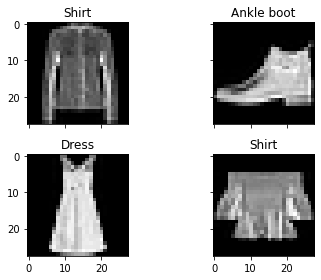

In [4]:
train_batch = next(train_iter)
# params: batch, classname, nrows, ncols
print(train_batch[1][:4])
# print(train_batch[1].squeeze(1))
# print(train_batch[1].squeeze(1).to(torch.long))
# print(train_batch[1].squeeze(1).to(torch.long).dtype)
display_from_batch(train_batch, 2, 2, classnames)

# return none

# 1_model

In [5]:
import torch
from torch import nn, optim

class MyCNN(nn.Module):
    def __init__(self, height, width, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=0)
        self.act1 = nn.ReLU()
        h = (height - 4)
        w = (width - 4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=0)
        self.act2 = nn.ReLU()
        h = (h - 4)
        w = (w - 4)
        self.pool2 = nn.MaxPool2d(2,2)
        h = h / 2
        w = w / 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.act3 = nn.ReLU()
        h = (h - 4)
        w = (w - 4)
        self.pool3 = nn.MaxPool2d(2,2)
        h = h / 2
        w = w / 2
        # 3x3 이미지가 됨
        self.fc4 = nn.Linear(64 * int(h) * int(w), 100)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(100, out_features)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        # 모듈화 필요>>>
        sizes = x.size()
        x = x.view(sizes[0], -1)
        # <<<모듈화 필요
        
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        return x


In [6]:
model = MyCNN(height=28, width=28, out_features=10)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list
print('MyCNN: ', sum(numel_list), numel_list)
from torchinfo import summary
summary(model, input_size=(1,1,28,28), device='cpu') 

MyCNN:  123222 [400, 16, 12800, 32, 51200, 64, 57600, 100, 1000, 10]


Layer (type:depth-idx)                   Output Shape              Param #
MyCNN                                    --                        --
├─Conv2d: 1-1                            [1, 16, 24, 24]           416
├─ReLU: 1-2                              [1, 16, 24, 24]           --
├─Conv2d: 1-3                            [1, 32, 20, 20]           12,832
├─ReLU: 1-4                              [1, 32, 20, 20]           --
├─MaxPool2d: 1-5                         [1, 32, 10, 10]           --
├─Conv2d: 1-6                            [1, 64, 6, 6]             51,264
├─ReLU: 1-7                              [1, 64, 6, 6]             --
├─MaxPool2d: 1-8                         [1, 64, 3, 3]             --
├─Linear: 1-9                            [1, 100]                  57,700
├─ReLU: 1-10                             [1, 100]                  --
├─Linear: 1-11                           [1, 10]                   1,010
Total params: 123,222
Trainable params: 123,222
Non-trainable params:

# 2_train

In [7]:
import torch
from torch import nn, optim
import collections
import tqdm
all_acc_dict = collections.OrderedDict()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import datetime
current_time = datetime.datetime.today() # 2021-08-15 20:58:43.302125
current_time = current_time.strftime('%Y%m%d%H%M%S') # 20210815205827

In [8]:
def eval_net(model, data_loader, device="cpu"):
    model.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        # y = y.squeeze(1).to(torch.long).to(device)
        with torch.no_grad():
            _, y_pred = model(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

In [9]:
n_epochs = 100

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_losses = []
train_acc = []
val_acc = []
for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    n = 0
    n_acc = 0
    # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
    for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        xx = xx.to(device)
        yy = yy.to(device)
        # yy = yy.squeeze(1).to(torch.long).to(device)
        h = model(xx)
        loss = loss_fn(h, yy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n += len(xx)
        _, y_pred = h.max(1)
        n_acc += (yy == y_pred).float().sum().item()
    train_losses.append(running_loss / i)
    # 훈련 데이터의 예측 정확도
    train_acc.append(n_acc / n)

    # 검증 데이터의 예측 정확도
    val_acc.append(eval_net(model, test_loader, device))
    print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
print('-----------training finished-----------')
print('train_losses: ', train_losses)
print('train_acc: ', train_acc)
print('val_acc: ', val_acc)

100%|██████████| 234/234 [00:05<00:00, 45.54it/s]


0 2.3018628241166534 0.10828993055555555 0.10546875


100%|██████████| 234/234 [00:04<00:00, 47.05it/s]


1 1.8194220076303114 0.3531650641025641 0.5470753312110901


100%|██████████| 234/234 [00:04<00:00, 46.86it/s]


2 0.9498021280305068 0.6480034722222222 0.6634615659713745


100%|██████████| 234/234 [00:04<00:00, 47.11it/s]


3 0.7949442029510957 0.7021067040598291 0.7095352411270142


100%|██████████| 234/234 [00:04<00:00, 47.29it/s]


4 0.7356180034481916 0.7242087339743589 0.73828125


100%|██████████| 234/234 [00:04<00:00, 47.41it/s]


5 0.6996430120243023 0.7399338942307693 0.75


100%|██████████| 234/234 [00:04<00:00, 47.36it/s]


6 0.6706724380474746 0.7503505608974359 0.7585136294364929


100%|██████████| 234/234 [00:05<00:00, 46.67it/s]


7 0.6451157735652678 0.7614850427350427 0.7591145634651184


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


8 0.6263081045109826 0.7685797275641025 0.7519030570983887


100%|██████████| 234/234 [00:04<00:00, 47.43it/s]


9 0.6077172669218334 0.7754573985042735 0.776442289352417


100%|██████████| 234/234 [00:04<00:00, 47.28it/s]


10 0.5928888331155409 0.7818175747863247 0.7755408883094788


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


11 0.5796954131689195 0.7872763087606838 0.7841546535491943


100%|██████████| 234/234 [00:04<00:00, 47.48it/s]


12 0.5630742930547362 0.7934194711538461 0.7914663553237915


100%|██████████| 234/234 [00:04<00:00, 47.34it/s]


13 0.5506209847497326 0.7975093482905983 0.7776442170143127


100%|██████████| 234/234 [00:04<00:00, 47.05it/s]


14 0.5389016086451486 0.8029513888888888 0.7924679517745972


100%|██████████| 234/234 [00:04<00:00, 47.27it/s]


15 0.526694319662618 0.8089610042735043 0.8008814454078674


100%|██████████| 234/234 [00:04<00:00, 47.38it/s]


16 0.5166175302773586 0.8095452724358975 0.8125


100%|██████████| 234/234 [00:04<00:00, 47.16it/s]


17 0.5072072373439314 0.8157885950854701 0.8133012652397156


100%|██████████| 234/234 [00:04<00:00, 47.29it/s]


18 0.5002347238585673 0.8181423611111112 0.8125


100%|██████████| 234/234 [00:04<00:00, 47.18it/s]


19 0.48945858985057716 0.8221487713675214 0.8129006624221802


100%|██████████| 234/234 [00:05<00:00, 46.70it/s]


20 0.4805831308016961 0.8241018963675214 0.8128004670143127


100%|██████████| 234/234 [00:04<00:00, 46.92it/s]


21 0.4739516331402529 0.8253372061965812 0.8204126954078674


100%|██████████| 234/234 [00:05<00:00, 45.46it/s]


22 0.4689443085838285 0.8291599893162394 0.8249198794364929


100%|██████████| 234/234 [00:04<00:00, 47.09it/s]


23 0.46161707941554647 0.832832532051282 0.825120210647583


100%|██████████| 234/234 [00:04<00:00, 47.24it/s]


24 0.4536956093342007 0.8344184027777778 0.8282251954078674


100%|██████████| 234/234 [00:04<00:00, 47.07it/s]


25 0.4493564560433826 0.8368389423076923 0.8324319124221802


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


26 0.4423412967137513 0.8387586805555556 0.8255208730697632


100%|██████████| 234/234 [00:04<00:00, 47.31it/s]


27 0.43870939563783967 0.8406617254273504 0.8138021230697632


100%|██████████| 234/234 [00:04<00:00, 46.94it/s]


28 0.43215812071198556 0.8426649305555556 0.822115421295166


100%|██████████| 234/234 [00:04<00:00, 46.86it/s]


29 0.4277253583265476 0.8449686164529915 0.8321314454078674


100%|██████████| 234/234 [00:04<00:00, 47.19it/s]


30 0.4241107521906431 0.8467214209401709 0.842848539352417


100%|██████████| 234/234 [00:04<00:00, 47.21it/s]


31 0.41690537090465235 0.8496928418803419 0.837740421295166


100%|██████████| 234/234 [00:04<00:00, 47.08it/s]


32 0.4155805434536013 0.8483907585470085 0.8349359035491943


100%|██████████| 234/234 [00:04<00:00, 47.31it/s]


33 0.4086747055657432 0.8530649038461539 0.8436498641967773


100%|██████████| 234/234 [00:04<00:00, 47.28it/s]


34 0.4049044163186151 0.8536992521367521 0.8386418223381042


100%|██████████| 234/234 [00:04<00:00, 47.36it/s]


35 0.4029401149360919 0.8539496527777778 0.8426482677459717


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


36 0.3986702011378538 0.856270032051282 0.8462539911270142


100%|██████████| 234/234 [00:04<00:00, 47.00it/s]


37 0.3927824359722915 0.8581563835470085 0.8438501954078674


100%|██████████| 234/234 [00:04<00:00, 47.05it/s]


38 0.38981787291207537 0.8599592681623932 0.8491586446762085


100%|██████████| 234/234 [00:04<00:00, 47.19it/s]


39 0.38502270430965996 0.8612446581196581 0.8415464758872986


100%|██████████| 234/234 [00:04<00:00, 46.92it/s]


40 0.3831967729355644 0.8619958600427351 0.8497596383094788


100%|██████████| 234/234 [00:04<00:00, 47.45it/s]


41 0.37859972006773235 0.8625467414529915 0.8515625


100%|██████████| 234/234 [00:04<00:00, 47.43it/s]


42 0.37573007478222825 0.8647836538461539 0.8520632982254028


100%|██████████| 234/234 [00:04<00:00, 47.38it/s]


43 0.3713625597851471 0.8662526709401709 0.8531650900840759


100%|██████████| 234/234 [00:04<00:00, 47.70it/s]


44 0.369392591420673 0.8669037126068376 0.8539663553237915


100%|██████████| 234/234 [00:04<00:00, 47.59it/s]


45 0.36292838647386033 0.8694411057692307 0.8556690812110901


100%|██████████| 234/234 [00:04<00:00, 47.04it/s]


46 0.3615543968943567 0.8689903846153846 0.85546875


100%|██████████| 234/234 [00:04<00:00, 47.35it/s]


47 0.3591298755146403 0.8698751335470085 0.8540664911270142


100%|██████████| 234/234 [00:04<00:00, 47.24it/s]


48 0.3541060015878964 0.8711104433760684 0.8567708730697632


100%|██████████| 234/234 [00:04<00:00, 47.19it/s]


49 0.35210628046498277 0.8725961538461539 0.8569711446762085


100%|██████████| 234/234 [00:04<00:00, 47.07it/s]


50 0.3493366827268969 0.8733306623931624 0.862379789352417


100%|██████████| 234/234 [00:04<00:00, 47.05it/s]


51 0.34715699452443183 0.8732972756410257 0.8319311141967773


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


52 0.3446800158770811 0.8750834668803419 0.8599759936332703


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


53 0.34270518883870904 0.875534188034188 0.8559695482254028


100%|██████████| 234/234 [00:04<00:00, 47.13it/s]


54 0.33939472608300236 0.8762853899572649 0.8605769276618958


100%|██████████| 234/234 [00:04<00:00, 47.16it/s]


55 0.33743167224104315 0.8774539262820513 0.8598757982254028


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


56 0.33517838445344195 0.8785890758547008 0.862379789352417


100%|██████████| 234/234 [00:04<00:00, 47.21it/s]


57 0.33356954170143144 0.8784555288461539 0.8613781929016113


100%|██████████| 234/234 [00:04<00:00, 47.37it/s]


58 0.32984834576880984 0.8801582532051282 0.8619791865348816


100%|██████████| 234/234 [00:04<00:00, 47.21it/s]


59 0.32764983273115283 0.8813601762820513 0.8634815812110901


100%|██████████| 234/234 [00:04<00:00, 47.06it/s]


60 0.3267152290871215 0.8798577724358975 0.8607772588729858


100%|██████████| 234/234 [00:04<00:00, 47.15it/s]


61 0.32224342578726267 0.8833299946581197 0.8643830418586731


100%|██████████| 234/234 [00:04<00:00, 47.28it/s]


62 0.3217614458737967 0.8818275908119658 0.8660857677459717


100%|██████████| 234/234 [00:04<00:00, 47.38it/s]


63 0.3200336743322053 0.8843649839743589 0.8615785241127014


100%|██████████| 234/234 [00:04<00:00, 47.35it/s]


64 0.31790437981038644 0.8837640224358975 0.8685897588729858


100%|██████████| 234/234 [00:04<00:00, 46.94it/s]


65 0.31636694489374695 0.8838975694444444 0.8625801205635071


100%|██████████| 234/234 [00:04<00:00, 47.11it/s]


66 0.3134734799421908 0.8846821581196581 0.8667868971824646


100%|██████████| 234/234 [00:04<00:00, 47.19it/s]


67 0.31126405560919146 0.8862680288461539 0.8615785241127014


100%|██████████| 234/234 [00:04<00:00, 47.27it/s]


68 0.30864765683724643 0.8883046207264957 0.8703926205635071


100%|██████████| 234/234 [00:04<00:00, 47.52it/s]


69 0.30959603311933676 0.8871026976495726 0.8730969429016113


100%|██████████| 234/234 [00:04<00:00, 47.28it/s]


70 0.30584692795133384 0.8876034989316239 0.8679887652397156


100%|██████████| 234/234 [00:04<00:00, 47.04it/s]


71 0.30320995553624475 0.8891392895299145 0.8667868971824646


100%|██████████| 234/234 [00:04<00:00, 46.92it/s]


72 0.3014721375422416 0.8897068643162394 0.8707932829856873


100%|██████████| 234/234 [00:04<00:00, 47.20it/s]


73 0.30170993231908444 0.890090811965812 0.8720953464508057


100%|██████████| 234/234 [00:04<00:00, 46.95it/s]


74 0.298802716857374 0.8910590277777778 0.8696914911270142


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


75 0.2975045393336996 0.8918603098290598 0.8705929517745972


100%|██████████| 234/234 [00:04<00:00, 47.38it/s]


76 0.2956705823732548 0.8912259615384616 0.8735977411270142


100%|██████████| 234/234 [00:04<00:00, 47.30it/s]


77 0.29469466689062734 0.8927283653846154 0.8718950152397156


100%|██████████| 234/234 [00:04<00:00, 47.26it/s]


78 0.29269185483199844 0.8919103899572649 0.8725961446762085


100%|██████████| 234/234 [00:04<00:00, 46.83it/s]


79 0.29110120313617804 0.8929954594017094 0.8731971383094788


100%|██████████| 234/234 [00:04<00:00, 47.30it/s]


80 0.2894224028858504 0.8939469818376068 0.8725961446762085


100%|██████████| 234/234 [00:04<00:00, 47.22it/s]


81 0.28668301766778265 0.8959668803418803 0.8706931471824646


100%|██████████| 234/234 [00:04<00:00, 47.11it/s]


82 0.28587179966750575 0.8957832532051282 0.8732972741127014


100%|██████████| 234/234 [00:04<00:00, 47.21it/s]


83 0.2848230242217559 0.8944310897435898 0.8713942170143127


100%|██████████| 234/234 [00:04<00:00, 47.19it/s]


84 0.2845222857888676 0.896217280982906 0.8692908883094788


100%|██████████| 234/234 [00:04<00:00, 47.31it/s]


85 0.2808308831611928 0.8969184027777778 0.872896671295166


100%|██████████| 234/234 [00:04<00:00, 47.24it/s]


86 0.280163276285061 0.8974025106837606 0.8736979365348816


100%|██████████| 234/234 [00:04<00:00, 47.00it/s]


87 0.2767464892674925 0.8983874198717948 0.8739984035491943


100%|██████████| 234/234 [00:04<00:00, 47.41it/s]


88 0.27634152162484343 0.8984875801282052 0.87109375


100%|██████████| 234/234 [00:04<00:00, 47.19it/s]


89 0.27667589344947635 0.8984041132478633 0.8756009936332703


100%|██████████| 234/234 [00:04<00:00, 47.06it/s]


90 0.2750039891751539 0.8990551549145299 0.8761017918586731


100%|██████████| 234/234 [00:04<00:00, 47.25it/s]


91 0.2730813500963056 0.8984208066239316 0.8729968070983887


100%|██████████| 234/234 [00:04<00:00, 47.60it/s]


92 0.27218814424434956 0.9001402243589743 0.876802921295166


100%|██████████| 234/234 [00:04<00:00, 47.02it/s]


93 0.2690366471402123 0.9011084401709402 0.8757011294364929


100%|██████████| 234/234 [00:04<00:00, 47.22it/s]


94 0.2687296110800919 0.9003238514957265 0.8784054517745972


100%|██████████| 234/234 [00:04<00:00, 47.18it/s]


95 0.2674978926074351 0.900924813034188 0.8787059187889099


100%|██████████| 234/234 [00:04<00:00, 47.39it/s]


96 0.2635407456128894 0.9037293002136753 0.8741987347602844


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


97 0.2649159450643564 0.9018596420940171 0.876802921295166


100%|██████████| 234/234 [00:04<00:00, 47.28it/s]


98 0.2612699606004191 0.9036959134615384 0.8742988705635071


100%|██████████| 234/234 [00:04<00:00, 47.50it/s]


99 0.261193945620193 0.9039463141025641 0.8746995329856873
-----------training finished-----------
train_losses:  [2.3018628241166534, 1.8194220076303114, 0.9498021280305068, 0.7949442029510957, 0.7356180034481916, 0.6996430120243023, 0.6706724380474746, 0.6451157735652678, 0.6263081045109826, 0.6077172669218334, 0.5928888331155409, 0.5796954131689195, 0.5630742930547362, 0.5506209847497326, 0.5389016086451486, 0.526694319662618, 0.5166175302773586, 0.5072072373439314, 0.5002347238585673, 0.48945858985057716, 0.4805831308016961, 0.4739516331402529, 0.4689443085838285, 0.46161707941554647, 0.4536956093342007, 0.4493564560433826, 0.4423412967137513, 0.43870939563783967, 0.43215812071198556, 0.4277253583265476, 0.4241107521906431, 0.41690537090465235, 0.4155805434536013, 0.4086747055657432, 0.4049044163186151, 0.4029401149360919, 0.3986702011378538, 0.3927824359722915, 0.38981787291207537, 0.38502270430965996, 0.3831967729355644, 0.37859972006773235, 0.37573007478222825, 0.371362559785147

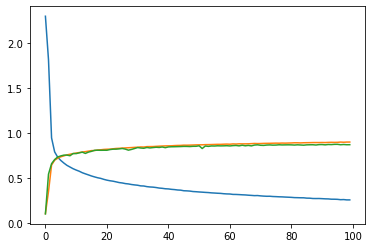

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_acc)
plt.plot(val_acc)